# Task: Predict the gold rate

## Data Exploration

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [3]:
df_ann = pd.read_csv("annual_gold_rate.csv")
df_ann.head()

Date     USD        EUR        GBP         INR         AED  CNY
0  1980-12-31  614.50  378.19461  263.80259  4831.74943  2278.36795  NaN
1  1981-12-31  459.26  360.90588  227.01948  3966.64790  1691.03194  NaN
2  1982-12-31  375.30  345.59742  215.53232  3553.62680  1378.72895  NaN
3  1983-12-30  423.66  439.89318  279.24936  4270.42821  1557.45790  NaN
4  1984-12-31  360.78  425.91000  269.81553  4067.60433  1324.72272  NaN

In [4]:
df_day = pd.read_csv("daily_gold_rate.csv")
df_day.head()

Date     USD     EUR     GBP      INR      AED    CNY
0  1985-01-01  308.30  402.45  266.01  3825.85  1134.42    NaN
1  1985-01-02  305.50  401.49  266.00  3787.05  1134.42    NaN
2  1985-01-03  302.30  397.08  262.76  3718.88  1107.67    NaN
3  1985-01-04  303.15  397.15  262.58  3759.64  1118.21    NaN
4  1985-01-07  298.25  392.55  261.17  3741.23  1091.58  835.8

In [5]:
df_day.describe().T

count          mean           std      min         25%        50%  \
USD  10114.0    799.552704    544.858424   252.80    356.6125    440.525   
EUR  10114.0    669.997853    463.177911   222.20    307.2900    375.070   
GBP  10114.0    540.951871    418.160576   156.89    221.5325    265.350   
INR  10114.0  43928.065703  43583.244790  3687.17  11748.6900  18305.155   
AED  10114.0   2936.556642   2001.379712   928.48   1310.9650   1617.855   
CNY  10110.0   5307.108772   3659.619165   809.63   2220.9500   3376.265   

            75%        max  
USD   1270.4500    2067.15  
EUR   1063.8375    1863.68  
GBP    884.7625    1634.97  
INR  79378.0625  167324.36  
AED   4666.3650    7592.64  
CNY   8326.2450   14373.93

In [6]:
df_day.isnull().sum()

Date    0
USD     0
EUR     0
GBP     0
INR     0
AED     0
CNY     4
dtype: int64

In [7]:
df_day["GBP"].describe().T

count    10114.000000
mean       540.951871
std        418.160576
min        156.890000
25%        221.532500
50%        265.350000
75%        884.762500
max       1634.970000
Name: GBP, dtype: float64

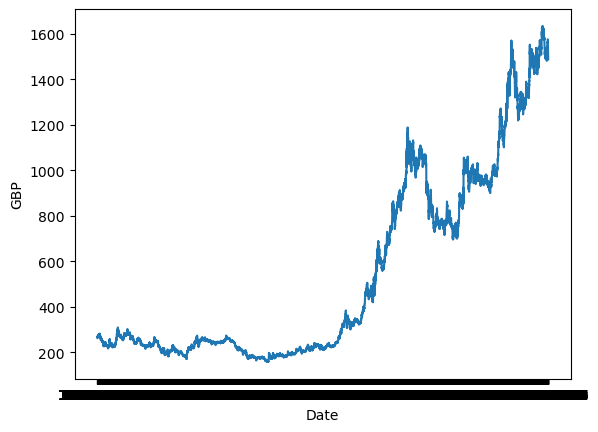

In [8]:
sns.lineplot(x = "Date", y = "GBP", data = df_day);

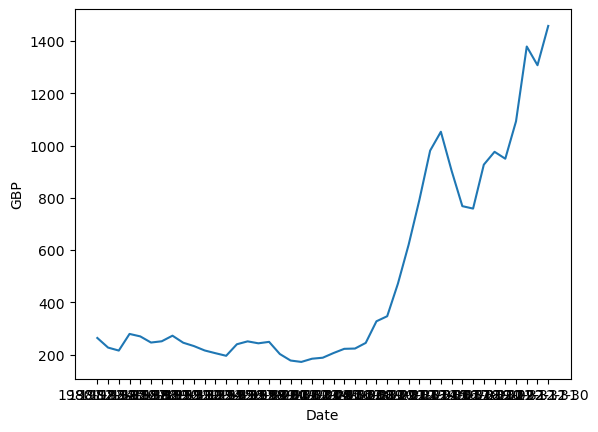

In [9]:
sns.lineplot(x = "Date", y = "GBP", data = df_ann);

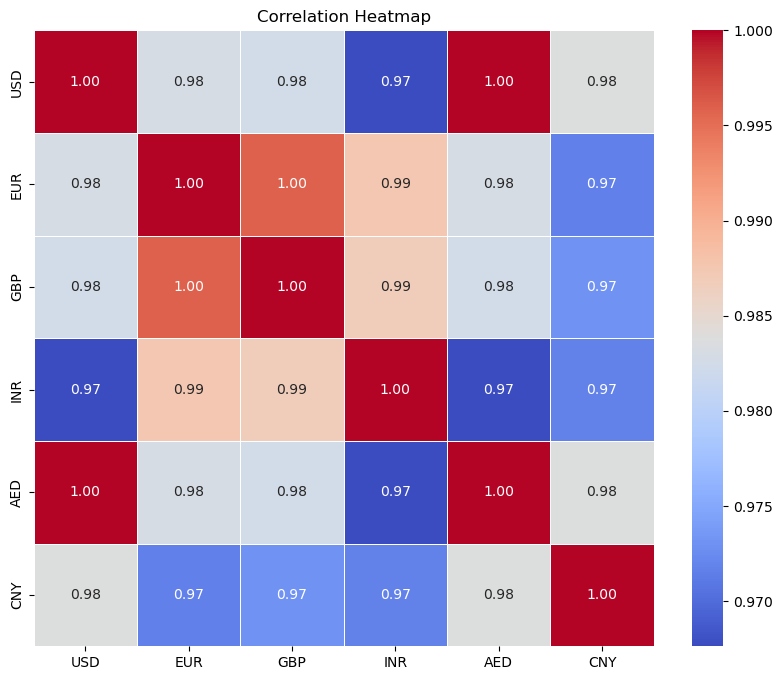

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix = df_day.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()


## Create Dataloader

### Use GBP ONLY

In [11]:
drop = ['EUR', 'USD','INR' , 'AED', 'CNY']
df = df_day.drop(drop, axis = 1)
df.head()

Date     GBP
0  1985-01-01  266.01
1  1985-01-02  266.00
2  1985-01-03  262.76
3  1985-01-04  262.58
4  1985-01-07  261.17

### Create Dataset and Dataloader

In [12]:
# convert timestamp to integer
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = (df['Date'] - df['Date'].min()).dt.days
df.head()

Date     GBP
0     0  266.01
1     1  266.00
2     2  262.76
3     3  262.58
4     6  261.17

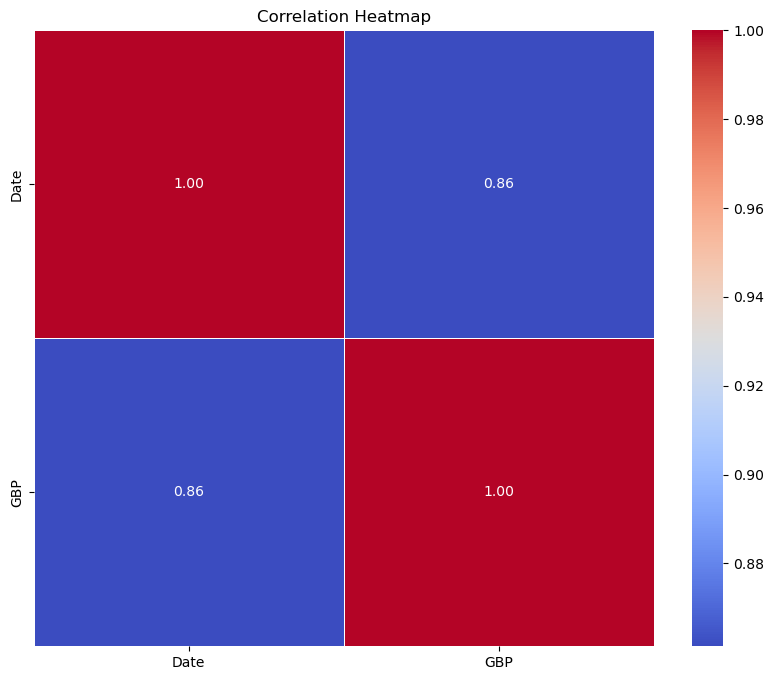

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Create dataloader
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class GoldPriceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        features = torch.tensor(self.dataframe.iloc[idx]['Date'], dtype=torch.float32)
        labels = torch.tensor(self.dataframe.iloc[idx]['GBP'], dtype=torch.float32)
        
        if self.transform:
            features = self.transform(features)
            labels = self.transform(labels)
            
        return features, labels

In [ ]:
dataset = GoldPriceDataset(df)

### Split train, test dataset

In [ ]:
# Normal split
from torch.utils.data import Subset

dataset_size = len(dataset)
train_size = int(dataset_size * 0.95)
test_size = dataset_size - train_size

train_dataset = Subset(dataset, range(0, train_size))
test_dataset = Subset(dataset, range(train_size, dataset_size))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Create Neural Network Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train and Test the model

### loss, optimizer

In [ ]:
import torch.optim as optim

net = Net()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.00001)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    net.train()
    for feature, targets in train_loader:
        inputs = feature.float()
        targets = targets.float()

        outputs = net(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
net.eval()
with torch.no_grad():
    for feature, targets in test_loader:
        inputs = feature.float()
        targets = targets.float()
        
        outputs = net(inputs)
        test_loss = criterion(outputs, targets)

    print(f'Test Loss: {test_loss.item():.4f}')

误差太大 不用全连接 用LSTM模型

## Create LSTM model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

df_lstm = pd.read_csv("daily_gold_rate.csv")
drop = ['EUR', 'USD','INR' , 'AED', 'CNY','Date']
df = df_lstm.drop(drop, axis = 1)

### Create Dataloader

In [2]:
# Create dataloader
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class GoldPriceDataset(Dataset):
    def __init__(self, dataframe, squence, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.squence = squence

    def __len__(self):
        return len(self.dataframe) - self.squence

    def __getitem__(self, idx):
        
        x = []
        temp = self.dataframe.iloc[idx:idx + self.squence + 1]

        
        # create x
        for i in range(len(temp) - 1):
            temp_x = ((temp.iloc[i]) - self.dataframe.min()) / (self.dataframe.max() - self.dataframe.min())
            x.append(torch.tensor(temp_x))
        
        # create y
        temp_y = ((temp.iloc[-1]) - self.dataframe.min()) / (self.dataframe.max() - self.dataframe.min())
        y = torch.tensor(temp_y)
        
        x = torch.stack(x, dim=0)
        
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
            
        return x, y

    # Normal split
from torch.utils.data import Subset

dataset = GoldPriceDataset(df,10)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.9)
test_size = dataset_size - train_size

#train_dataset = Subset(dataset, range(0, train_size))
test_dataset = Subset(dataset, range(train_size, dataset_size))

train_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### LSTM model structure

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=64,
            num_layers=1, 
            batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(64,1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)
        out = self.out(r_out[:, -1, :])
        
        return out

### Training and Testing process

In [4]:
model = LSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training
epochs = 200
best_loss = float('inf')
for epoch in range(epochs):
    print(epoch)
    for inputs, targets in train_loader:
        inputs = inputs.float()
        targets = targets.float()
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()

        optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_model4.pth')

0
Epoch [1/200], Loss: 0.0006
1
Epoch [2/200], Loss: 0.0005
2
Epoch [3/200], Loss: 0.0006
3
Epoch [4/200], Loss: 0.0006
4
Epoch [5/200], Loss: 0.0006
5
Epoch [6/200], Loss: 0.0005
6
Epoch [7/200], Loss: 0.0004
7
Epoch [8/200], Loss: 0.0003
8
Epoch [9/200], Loss: 0.0002
9
Epoch [10/200], Loss: 0.0001
10
Epoch [11/200], Loss: 0.0001
11
Epoch [12/200], Loss: 0.0001
12
Epoch [13/200], Loss: 0.0001
13
Epoch [14/200], Loss: 0.0001
14
Epoch [15/200], Loss: 0.0001
15
Epoch [16/200], Loss: 0.0001
16
Epoch [17/200], Loss: 0.0001
17
Epoch [18/200], Loss: 0.0000
18
Epoch [19/200], Loss: 0.0000
19
Epoch [20/200], Loss: 0.0000
20
Epoch [21/200], Loss: 0.0000
21
Epoch [22/200], Loss: 0.0000
22
Epoch [23/200], Loss: 0.0000
23
Epoch [24/200], Loss: 0.0000
24
Epoch [25/200], Loss: 0.0000
25
Epoch [26/200], Loss: 0.0000
26
Epoch [27/200], Loss: 0.0000
27
Epoch [28/200], Loss: 0.0000
28
Epoch [29/200], Loss: 0.0000
29


In [5]:
# Testing
model = LSTM()
model.load_state_dict(torch.load('best_model4.pth', map_location=torch.device('cpu')))
model.eval()
y_pred_list = []
actual = []
with torch.no_grad():
    for feature, targets in test_loader:
        inputs = feature.float()
        targets = targets.float()
        
        outputs = model(inputs)
        test_loss = criterion(outputs, targets)
        y_pred_list.append(outputs.squeeze(1).tolist())
        actual.append(targets.squeeze(1).tolist())

    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0000


In [6]:
print(y_pred_list)

[[0.7467237114906311], [0.7498753666877747], [0.7430073022842407], [0.7427148222923279], [0.7410719990730286], [0.7403230667114258], [0.7417866587638855], [0.7424575686454773], [0.7466855049133301], [0.7408637404441833], [0.7376277446746826], [0.7306426167488098], [0.7310468554496765], [0.731059193611145], [0.7333109974861145], [0.7378913760185242], [0.7258270382881165], [0.731518566608429], [0.7410468459129333], [0.7432796359062195], [0.7472947239875793], [0.7489323019981384], [0.7549196481704712], [0.754105269908905], [0.7534757256507874], [0.7526247501373291], [0.7576425671577454], [0.7572702765464783], [0.7570528388023376], [0.7565962672233582], [0.7615262866020203], [0.7749118208885193], [0.782477617263794], [0.7811765074729919], [0.7834749817848206], [0.7737914323806763], [0.7742529511451721], [0.7754529118537903], [0.7711898684501648], [0.772603452205658], [0.7728739976882935], [0.7776731848716736], [0.7804582715034485], [0.7731250524520874], [0.7708632946014404], [0.77464765310

### Visual

### Scatter

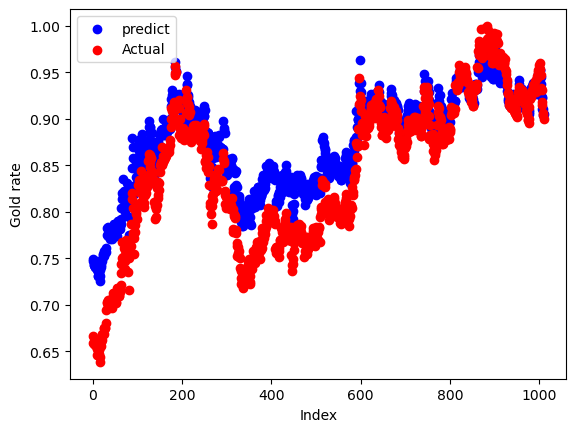

In [7]:
import matplotlib.pyplot as plt

plt.scatter(range(len(y_pred_list)), y_pred_list, color='blue', label='predict')
plt.scatter(range(len(actual)),actual, color='red', label='Actual')

plt.xlabel('Index')
plt.ylabel('Gold rate')
plt.legend()

plt.show()


### Line

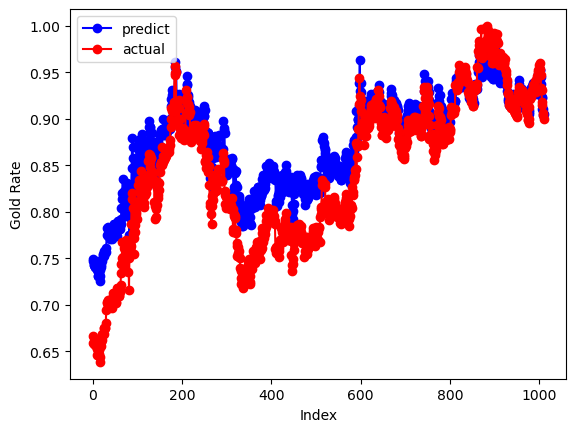

In [8]:
plt.plot(range(len(y_pred_list)), y_pred_list, color='blue', label='predict', marker='o')
plt.plot(range(len(actual)), actual, color='red', label='actual', marker='o')

plt.xlabel('Index')
plt.ylabel('Gold Rate')
plt.legend()

plt.show()

## Use day input to predict the gold rate

In [ ]:
from datetime import datetime

def days_since_1985(timestamp):
    date_format = "%Y-%m-%d"
    start_date = datetime.strptime("1985-01-01", date_format)
    given_date = datetime.strptime(timestamp, date_format)
    delta = given_date - start_date
    return delta.days

In [ ]:
inputs = torch.tensor(days_since_1985("2021-01-01")).float().unsqueeze(0)
new_tensor = inputs.unsqueeze(0)

In [ ]:
out = net(new_tensor)